iteration:  0
success  6.456756591796875
iteration:  1
success  8.2092604637146
iteration:  2
success  10.642372131347656
iteration:  3
success  11.014731168746948
iteration:  4
success  9.599905490875244
iteration:  5
success  9.268195629119873
iteration:  6
success  9.649648189544678
iteration:  7
success  10.392385721206665
iteration:  8
success  11.177291631698608
iteration:  9
success  11.807000160217285
iteration:  10
success  11.694546937942505
iteration:  11
success  11.300364971160889
iteration:  12
success  9.970794677734375
iteration:  13
success  15.367578506469727
iteration:  14
success  13.391704082489014
iteration:  15
success  14.487188816070557
iteration:  16
success  12.495449304580688
iteration:  17
success  11.958019971847534
iteration:  18
success  11.768305540084839
iteration:  19
success  12.750421285629272
iteration:  20
success  13.698795557022095
iteration:  21
success  13.96086597442627
iteration:  22
success  14.78344464302063
iteration:  23
success  16.4144

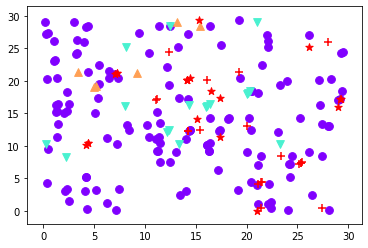

In [9]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import io
import time
import scipy.signal
import scipy
import torch


class CountingGrid_GPU():
    def __init__(self,grid_size,window_size,n_features):
        np.random.seed(7)
        self.grid_size = grid_size
        self.window_size = window_size
        self.n_features = n_features # No. of features
        rand_init_pi = 1 + np.random.rand(self.n_features,self.grid_size[0],self.grid_size[1])
        self.p_grid = torch.cuda.FloatTensor(rand_init_pi/sum(rand_init_pi,0))
        self.smoothed_grid=np.zeros((self.n_features,self.grid_size[0],self.grid_size[1]))
        self.smooth_grid()

    def smooth_grid(self):
        start=time.time()
        if self.smoothed_grid.dtype!='float64':
            self.smoothed_grid=self.smoothed_grid.cpu().numpy()
        for z in range(0,self.n_features):
            self.smoothed_grid[z,:,:]=scipy.ndimage.uniform_filter(self.p_grid[z,:,:].cpu().numpy(),size=(self.window_size,self.window_size),mode='wrap').astype('float32')
        self.smoothed_grid=torch.cuda.FloatTensor(self.smoothed_grid)
        end=time.time()


    def e_step(self,X):
        self.embedding=torch.exp(X@torch.log(self.smoothed_grid.reshape(self.n_features,\
                        self.grid_size[0]*self.grid_size[1])))
        self.embedding=self.embedding\
                        .reshape(X.shape[0],self.grid_size[0],self.grid_size[1])
        self.embedding=self.embedding/sum(self.embedding)

    def compute_div(self,n_samples):
        div=torch.cuda.FloatTensor(np.zeros((n_samples,self.n_features,self.grid_size[0],self.grid_size[1])))
        for t in range(n_samples):
            for z in range(self.n_features):
                div[t,z,:,:]=self.embedding[t,:,:]/self.smoothed_grid[z,:,:]
        return div

    def m_step(self,X):
        self.p_grid=torch.cuda.FloatTensor(self.p_grid)
        self.p_grid_old=self.p_grid.clone()
        start=time.time()
        div=self.compute_div(X.shape[0])
        #pad
        tensors=[div, div[:,:,:,0:self.window_size+1]]
        div_pad_left=torch.cat(tensors,-1)
        tensors=[div_pad_left,div_pad_left[:,:,0:self.window_size+1,:]]
        div_pad_bottom=torch.cat(tensors,2)
        div=div_pad_bottom
        for i1 in range(self.grid_size[0]):
            for i2 in range(self.grid_size[1]):
                div_sum=torch.sum(div[:,:,i1:i1+self.window_size,
                i2:i2+self.window_size].reshape(X.shape[0],
                self.n_features,-1),axis=-1)
                dot=torch.sum(X*div_sum,axis=0)
                self.p_grid[:,i1,i2]=self.p_grid_old[:,i1,i2]*dot
        self.p_grid=self.p_grid/torch.sum(self.p_grid,0)
        self.smooth_grid()
        end=time.time()
        print('success ',end-start)


    def fit(self,X):
        start=time.time()
        X=torch.cuda.FloatTensor(X)
        for i in range(0,25):
            print('iteration: ',i)
            self.e_step(X)
            self.m_step(X)
        end=time.time()
        print('all loop',end-start)

    def cg_plot(self,labels):
      '''Currently supports 5 different symbols,
      the labels have to be numbers between 0-4
      for the code to work.
      '''
      lab = np.unique(labels)
      L = len(lab)
      for i in range(0,L):
          ids = np.where(labels==lab[i])[0]
          if i==0:
              marker='o'
          if i==1:
              marker='v'
          if i==2:
              marker='^'
          if i==3:
              marker='*'
          if i==4:
              marker='+'
          for t in range(0,len(ids)):
              temp = self.embedding.cpu().numpy()[ids[t],:,:]
              x,y = np.unravel_index(temp.argmax(), temp.shape)
              noise = 0.5*np.random.rand(1)
              plt.scatter(x+noise,y+noise, marker=marker,s=60,color=cm.rainbow(i*100))
      plt.show()

from scipy import io
import numpy as np

'''
This is an example of using the CountingGrid
class on lung cancer gene expression data.
'''

def filter_by_variance(X,nr_of_features_to_keep):
    '''
    Function for thresholding data by variance,
    keeping only 'nr_of_features_to_keep' features
    with the highest variance.
    X=[nr_of_samples, nr_of_features]
    '''
    ordering = np.argsort(np.var(X,axis=0))[::-1]
    threshold = ordering[0:nr_of_features_to_keep]
    X=X[:,threshold]
    return X

#Preparing the data
data = io.loadmat('lung_bhattacherjee.mat')
X= data['data']
Y_labels = data['sample_names'][0]
X= X.T
X = filter_by_variance(X,200)
#Compose labels matrix from filec
Y=np.zeros((len(Y_labels),1))
for j in range(0,len(Y_labels)):
    if str(Y_labels[j][0])[0:3]=='AD-':
        Y[j]=0
    if str(Y_labels[j][0])[0:3]=='NL-':
        Y[j]=1
    if str(Y_labels[j][0])[0:3]=='SMC':
        Y[j]=2
    if str(Y_labels[j][0])[0:3]=='SQ-':
        Y[j]=3
    if str(Y_labels[j][0])[0:3]=='COI':
        Y[j]=4

#Usage
X=X/np.sum(X,axis=0)
cg_obj=CountingGrid_GPU([30,30],3,200)
cg_obj.fit(X)
cg_obj.cg_plot(Y)
pi=cg_obj.p_grid
emb=cg_obj.embedding
h=cg_obj.smoothed_grid

torch.Size([200, 30, 30])


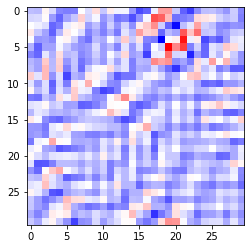

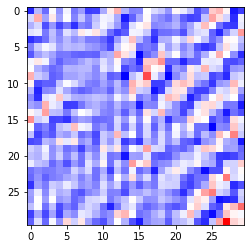

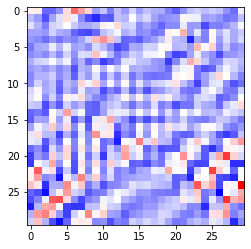

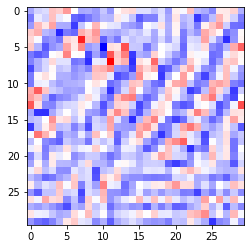

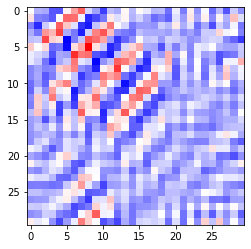

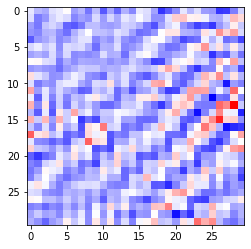

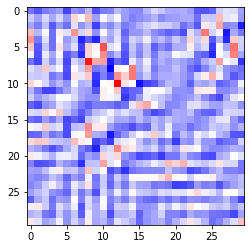

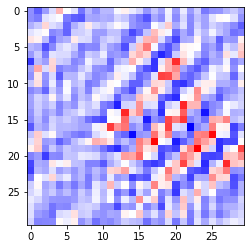

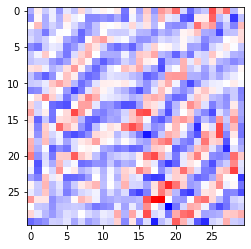

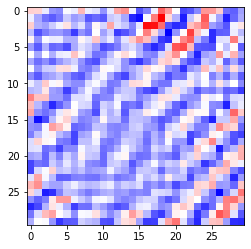

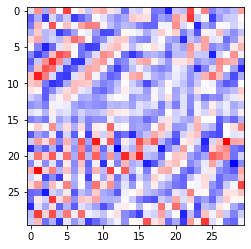

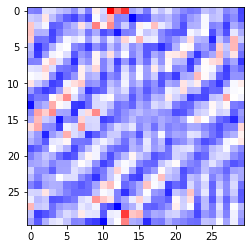

KeyboardInterrupt: 

In [10]:
print(h.shape)
for j in range(0,200):
    plt.imshow(h[j,:,:].cpu().numpy(),cmap='bwr')
    plt.show()

In [11]:
print(emb.shape)

torch.Size([203, 30, 30])


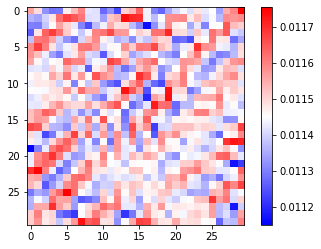

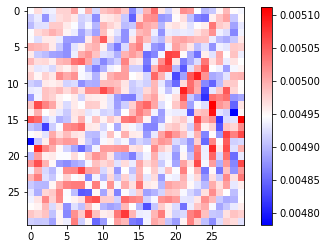

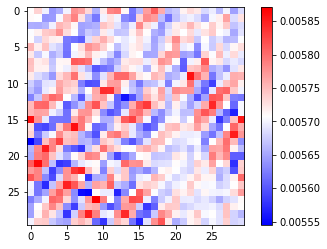

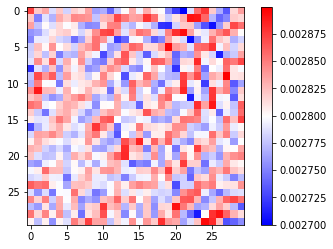

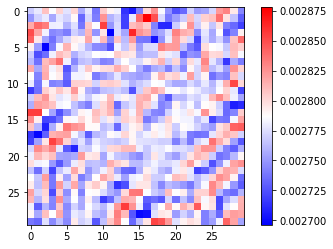

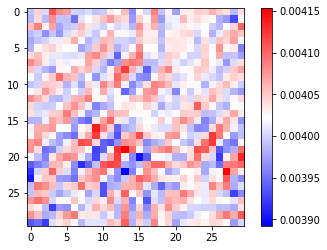

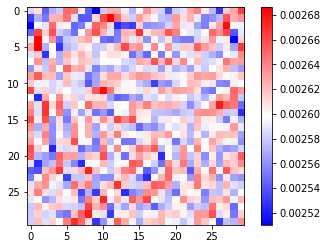

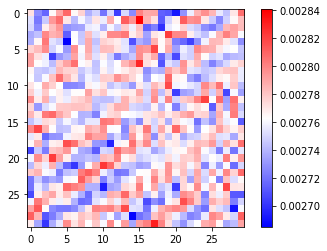

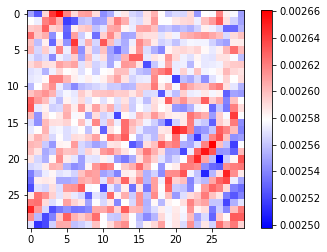

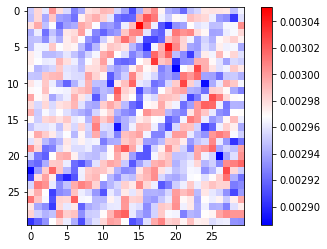

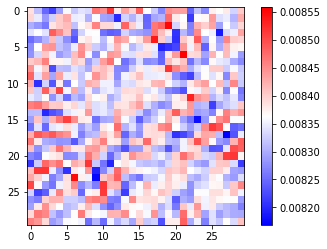

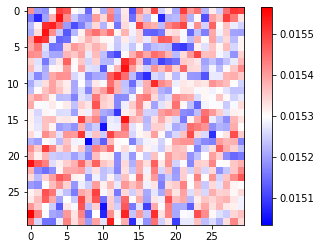

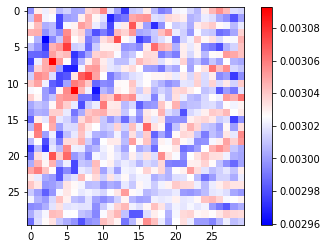

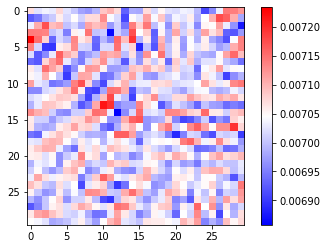

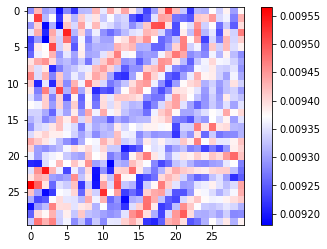

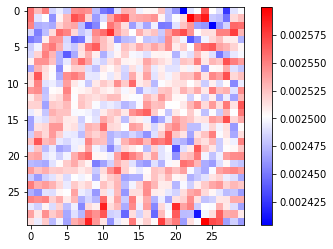

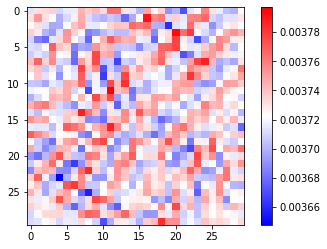

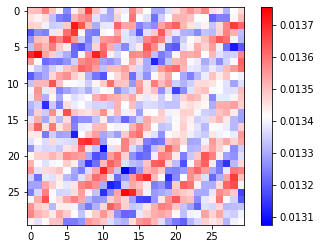

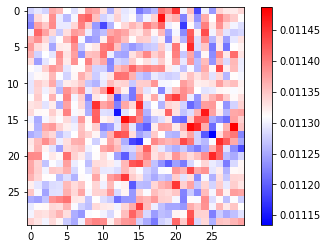

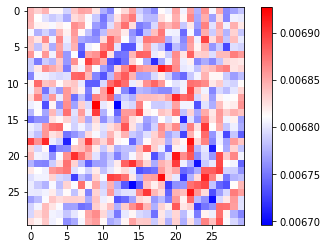

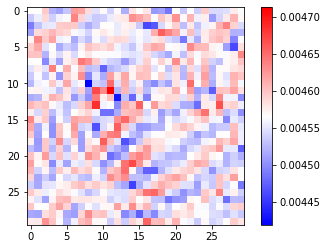

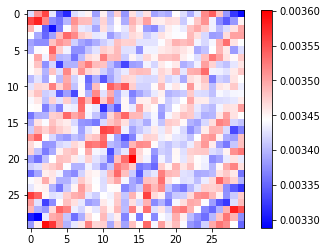

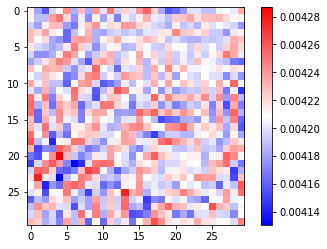

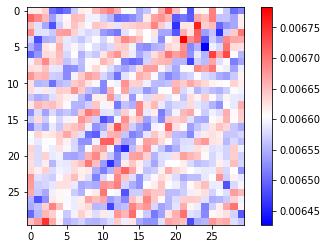

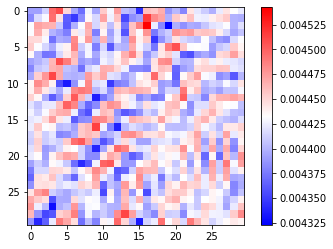

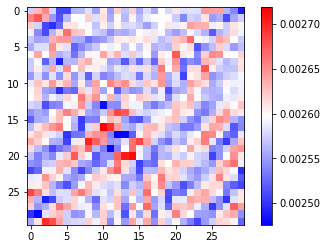

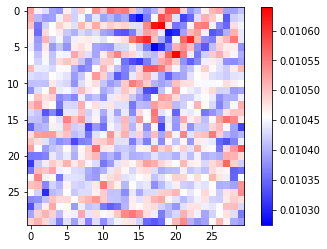

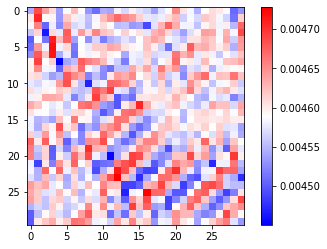

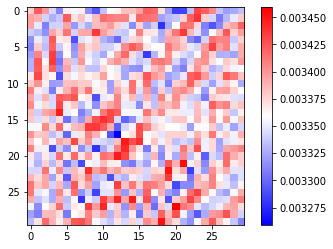

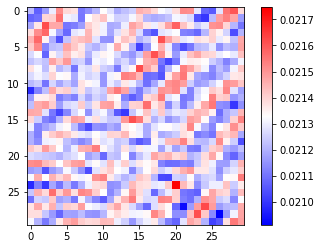

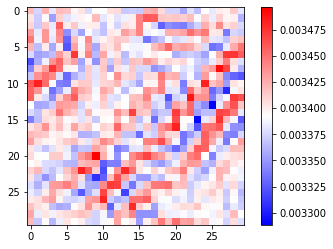

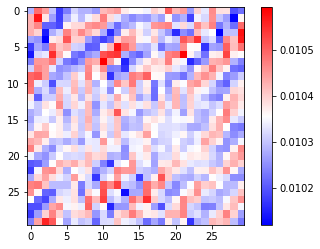

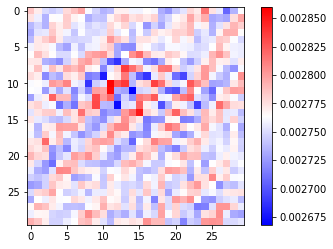

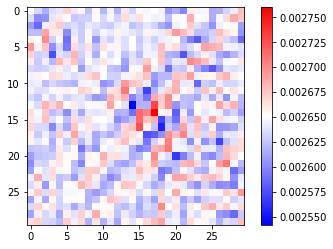

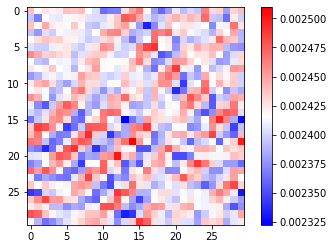

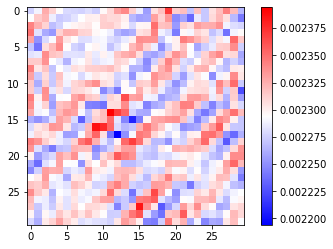

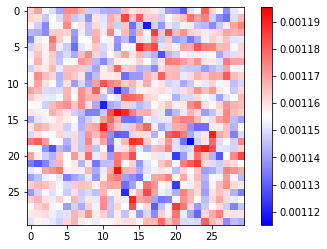

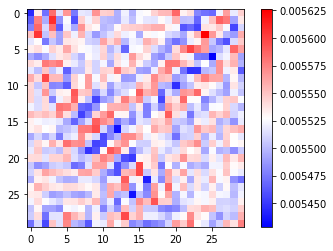

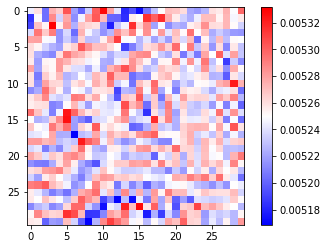

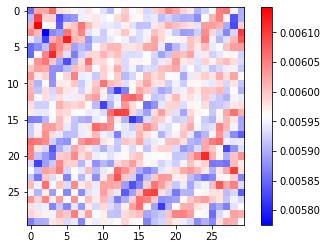

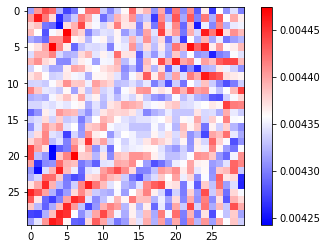

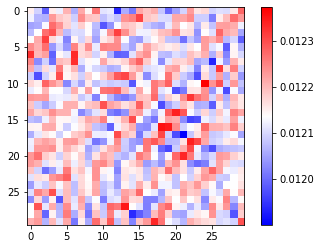

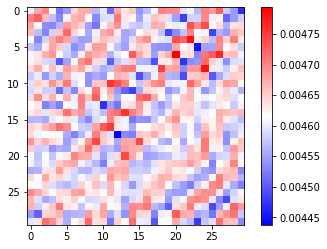

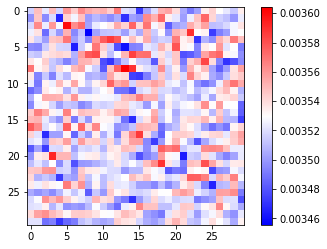

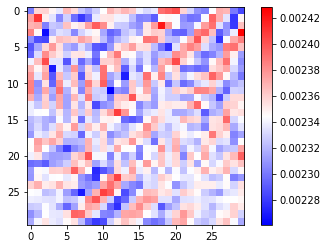

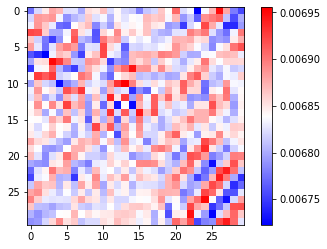

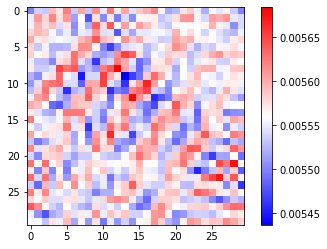

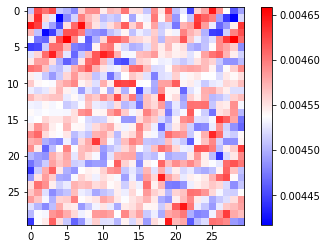

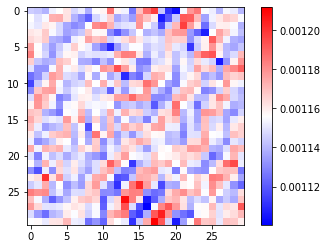

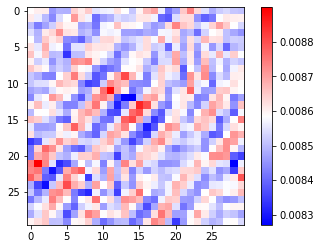

In [13]:
for j in range(0,50):
    plt.imshow(emb.cpu().numpy()[j,:,:],cmap='bwr')
    plt.colorbar()
    plt.show()

torch.Size([200, 30, 30])


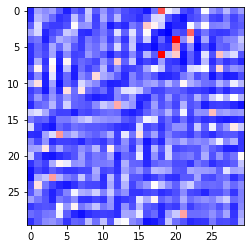

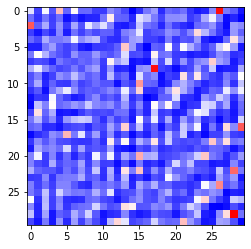

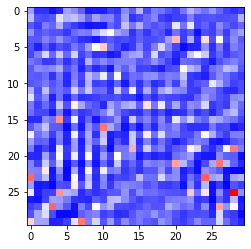

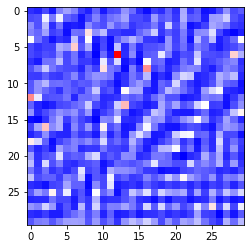

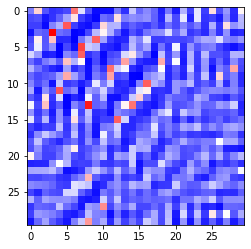

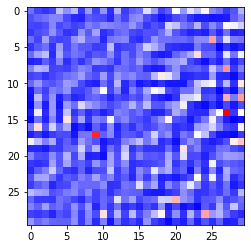

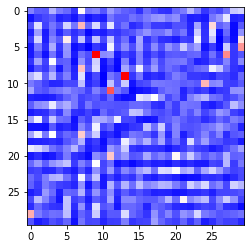

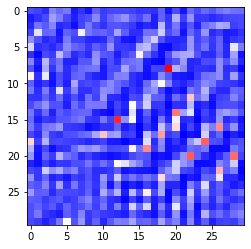

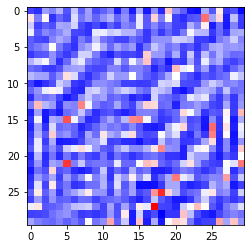

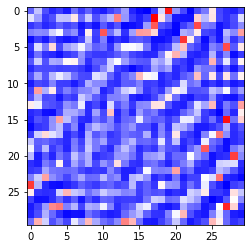

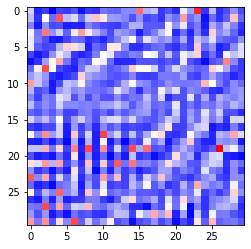

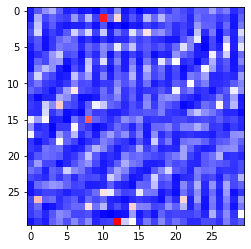

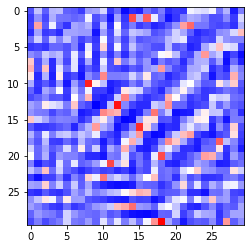

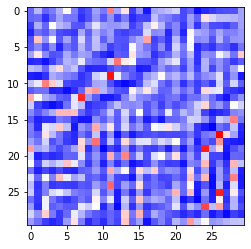

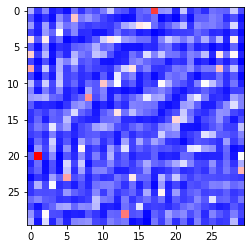

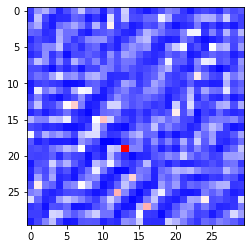

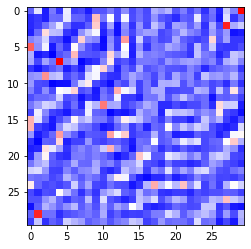

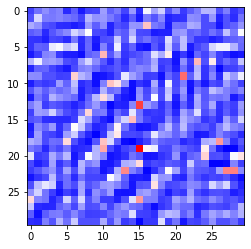

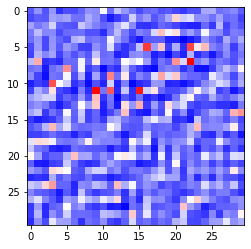

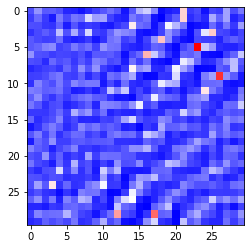

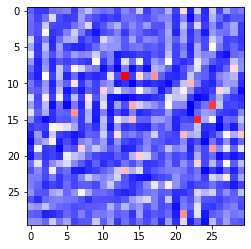

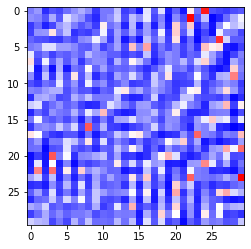

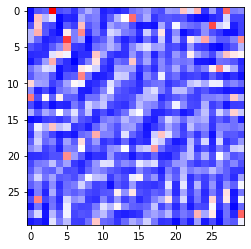

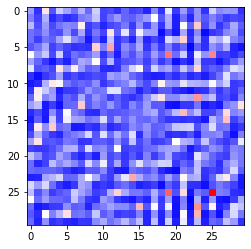

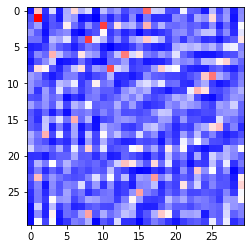

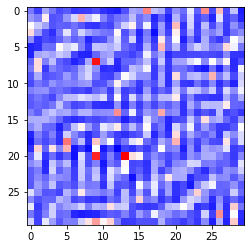

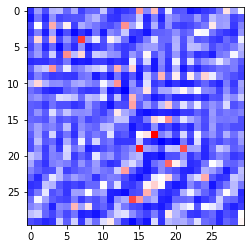

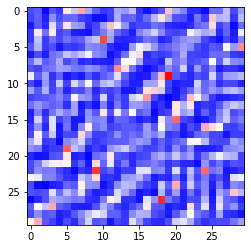

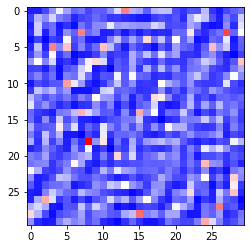

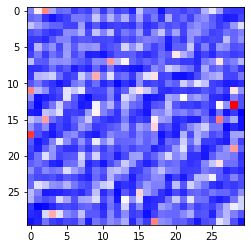

In [15]:
print(pi.shape)
for j in range(0,30):
    plt.imshow(pi.cpu().numpy()[j,:,:],cmap='bwr')
    plt.show()